Zach Wilson
April 23 2025
CNN Color Polygon recongnition, Baseline 57%

Import libraries to be used.

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.data import Dataset
from tensorflow.keras import datasets
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, RandomRotation, Rescaling, RandomZoom, RandomTranslation
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

Print labels to see data distribution.

In [241]:
import pandas as pd
import os

# Load labels
csv_path = "../Poly/targets.csv"  

df = pd.read_csv(csv_path)

# Peek at data
print(df.head())


   Unnamed: 0                                  filename  sides bg_color  \
0           0  70aaa621-1345-4541-a954-ee9856daaf18.png      4     blue   
1           1  ea0d8d14-596a-4365-b007-6325fc96e0f4.png      3    black   
2           2  48c1fc5a-8b6b-4555-bb6a-a7d42a5cedc2.png      4   yellow   
3           3  ad721906-604c-4682-ae5d-15539ef1dbc7.png      3    green   
4           4  510dd5ea-fb92-432e-91cc-ed4654a03ebd.png      6    white   

  fg_color  bound_circle_x  bound_circle_y  bound_circle_r  rotation  
0     pink              29              39              15       185  
1   yellow              66              66              21       215  
2      red              59             103              20        59  
3     pink              65              66              61       272  
4    green              48              56              42        38  


After reading and seeing some information about the data, load the data, resize, and normalize.

To properly function I must remove the unwanted labels from the index of 0-2, and 7-10.
Then I remap the shapes to the index of 0-3 to align with the shapes (triangle, square, pentagon, hexagon)



In [ ]:
# Constants
IMG_DIR = "../Poly/images/content/images"
IMG_SIZE = (128, 128)

# Extract filenames and labels
filepaths = df['filename'].apply(lambda x: os.path.join(IMG_DIR, x)).values

df = df[df['sides'].isin([3, 4, 5, 6])].reset_index(drop=True) #include specific polygon shapes
label_map = {3: 0, 4: 1, 5: 2, 6: 3} #remap the sphapes to 0-3 to match "SHAPES"
labels = df['sides'].map(label_map).values


# Function to load and preprocess each image
def process_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=1) #greyscale
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

Next I split the data into training, validation, and testing sets giving 10% to filepathes_test and Labels_test, and 90% to Filepaths_trainval and Labels_trainval.
Then using that 90% I give 20% of that for validation, and the remaining is used for training.

In [ ]:
# Shuffle the data
from sklearn.model_selection import train_test_split

#Split into train+val and test
filepaths_trainval, filepaths_test, labels_trainval, labels_test = train_test_split(
    filepaths, labels, test_size=0.1, random_state=42)

#Split train+val into train and val
filepaths_train, filepaths_val, labels_train, labels_val = train_test_split(
    filepaths_trainval, labels_trainval, test_size=0.2, random_state=42)


Build the dataset and batch it for parallelization

In [244]:
def build_dataset(filepaths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    ds = ds.map(process_image)
    ds = ds.batch(32)
    return ds

train_ds = build_dataset(filepaths_train, labels_train, shuffle=True)
val_ds   = build_dataset(filepaths_val, labels_val)
test_ds  = build_dataset(filepaths_test, labels_test)


Print the size of the test data to ensure it a good size with various examples

In [245]:
print("Test set size:", len(filepaths_test))


Test set size: 1000


Working to increase the accuracy from the baseline, I implement data augmentation to prevent overfitting

In [246]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])


Sequential CNN Model using pooling layers.

After seeing the sporadic nature of the Training and validation accuracy curves, I add batch normalization, to help speed up convergence.
My initial CNN, consisted of multiple layers of dropout. Once I noticed that my training accuracy was severly lower than my validation from the graph, I removed the dropout, allowing for my model to learn past the local minimum previously found.

In [247]:
def cnn_model(input_shape=(128, 128, 1), num_classes=10):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        #layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


Instantiate and compile the CNN choosing an optimizer and a loss function, including accuracy as a metric.

In [248]:
model = cnn_model(input_shape=(128, 128, 1), num_classes=10)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train on GPU

In [249]:
import tensorflow as tf

# Print list of available physical devices
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Record the history of the model as I train it over 20 epochs passing both training and validation sets.

In [250]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2722 - loss: 6.2926 - val_accuracy: 0.2822 - val_loss: 1.4180
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3333 - loss: 1.3471 - val_accuracy: 0.3367 - val_loss: 1.3681
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3545 - loss: 1.3091 - val_accuracy: 0.3833 - val_loss: 1.3700
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.3882 - loss: 1.2746 - val_accuracy: 0.4067 - val_loss: 1.2545
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4026 - loss: 1.2230 - val_accuracy: 0.3528 - val_loss: 1.7816
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4418 - loss: 1.1828 - val_accuracy: 0.4500 - val_loss: 1.2019
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4491 - loss: 1.1632 - val_accuracy: 0.4344 - val_loss: 1.3948
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4914 - loss: 1.0868 - val_accu

After training, show the training accuracy as well as the testing accuracy.

In [251]:
train_loss, train_acc = model.evaluate(train_ds)
print(f"Train accuracy: {train_acc:.2%}")


test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2%}")


 10/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9257 - loss: 0.2121 

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9042 - loss: 0.2503
Train accuracy: 90.31%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8982 - loss: 0.2633
Test accuracy: 89.40%


Plot the Training and Validation accuracy over epochs to visualize training results to help drive network update decisions.

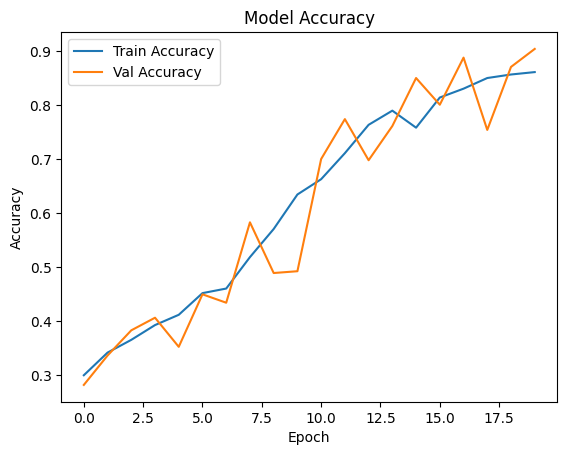

In [256]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Process the images to be visualized as shown in the Baseline kaggle notebook.
Unbatch to single images and append to respective list (image, label) and make them arrays.

In [ ]:
X_test, y_test = [], []
for img, label in test_ds.unbatch():
    X_test.append(img.numpy())
    y_test.append(label.numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

SHAPES = ['Triangle', 'Square', 'Pentagon', 'Hexagon']  # 0-3 mapping to shapes


Find out what the expected shape of the output is versus what you have declared in SHAPES

In [254]:
print("Model output shape:", model.output_shape)
print("SHAPES:", SHAPES)


Model output shape: (None, 10)
SHAPES: ['Triangle', 'Square', 'Pentagon', 'Hexagon']


Evaluation on unseen images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


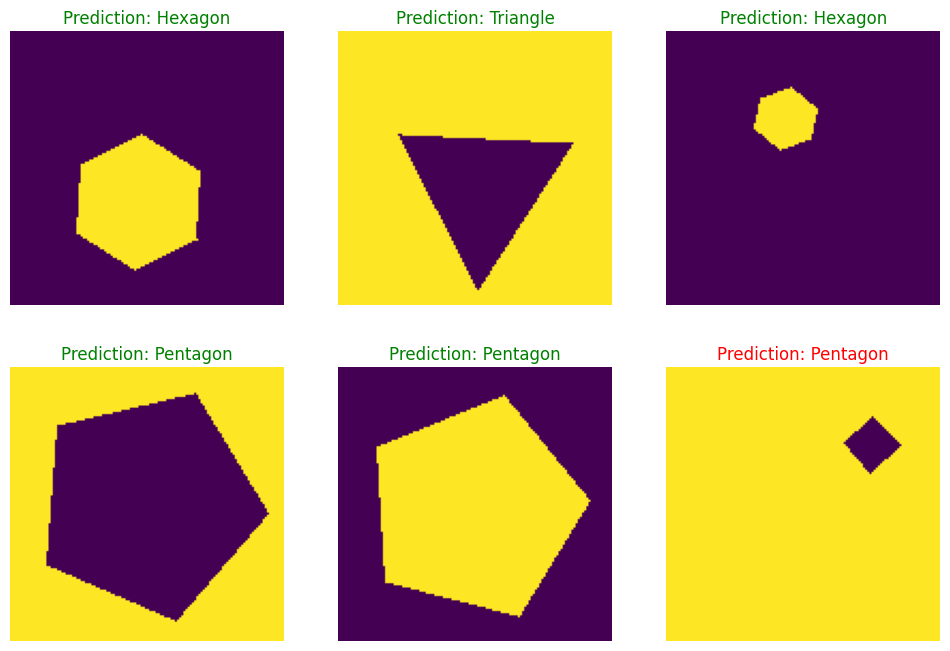

In [258]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=[12, 8])
for i in range(1, 7):
    rand_idx = randint(0, len(X_test)-1)
    img = X_test[rand_idx]
    pred = model.predict(np.expand_dims(img, axis=0)).argmax()
    label = int(y_test[rand_idx])

    plt.subplot(2, 3, i)
    plt.imshow(img.squeeze(), cmap=None) 
    plt.axis("off")
    plt.title(f"Prediction: {SHAPES[pred]}", 
              color="green" if pred == label else "red")
plt.show()


Resources:

[1] K. Bhutani, “Python|Pandas DataFrame.isin()”, GeeksforGeeks, [Online]. Available: https://www.geeksforgeeks.org/python-pandas-dataframe-isin/. [Accessed: Apr. 23, 2025].

[2] G. Recio, “Color Polygon Images”, Kaggle Datasets, [Online]. Available: https://www.kaggle.com/datasets/gonzalorecioc/color-polygon-images. [Accessed: Apr. 23, 2025].

[3] G. Recio, “Beat my model! Shape Classifier 57% accuracy”, Kaggle Notebooks, [Online]. Available: https://www.kaggle.com/code/gonzalorecioc/beat-my-model-shape-classifier-57-accuracy. [Accessed: Apr. 23, 2025].

[4] NNDesignDeepLearning, “NNDesignDeepLearning GitHub Repository”, GitHub, [Online]. Available: https://github.com/NNDesignDeepLearning/NNDesignDeepLearning. [Accessed: Apr. 23, 2025].

